# Preparation

## Import Libraries

In [ ]:
!apt-get update && apt-get install -y python3-opencv

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [917 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.lau

In [2]:
!pip install timm

     |████████████████████████████████| 431 kB 12.8 MB/s eta 0:00:01


In [1]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, average_precision_score
import seaborn as sns
import timm

In [2]:
model_name = 'regnetz_b16'
model = timm.create_model(model_name, pretrained=False)
model
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-attn-weights/regnetz_b_raa-677d9606.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.94,
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'first_conv': 'stem.conv',
 'classifier': 'head.fc',
 'test_input_size': (3, 288, 288),
 'architecture': 'regnetz_b16'}

## Connect google drive & Change directory

## Set Arguments & hyperparameters

In [5]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [6]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= '/USER/data'
NUM_CLS = 2

EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = 384
K_FOLDS = 5

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# check device
DEVICE

device(type='cuda')

## Data Augmetation

In [8]:

# Set Augmentation variable
VFLIP = True
HFLIP = True
ROTATE = True
FLIP_ROTATE = True
ANGLE = None

In [9]:
# ./data/augmentation 위치에 이미지를 생성하도록 만듦
# vflip : 상하로 뒤집을건지, hflip : 좌우로 뒤집을건지, rotate : 회전을 할건지 (한다면) angle : 지정한값으로 할건지(비우면 random)
def createimage(vflip=True, hflip=True, rotate=True, flip_rotate=True, angle=None):
    origin_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
    origin_df = origin_df[:578]

    # save original image
    for i in tqdm(range(578)):
        img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
        cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}.png', img)
        

    # vertical flip
    if vflip:
        for i in tqdm(range(578)):
            img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
            vflip_img = cv2.flip(img, 0)
            cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}_vflip.png', vflip_img)
            origin_df.loc[len(origin_df)] = [f'{i}_vflip.png', origin_df.iloc[i]['COVID']]

        
    # horizontal filp
    if hflip:
        for i in tqdm(range(578)):
            img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
            hflip_img = cv2.flip(img, 1)
            cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}_hflip.png', hflip_img)
            origin_df.loc[len(origin_df)] = [f'{i}_hflip.png', origin_df.iloc[i]['COVID']]

    # rotate
    if rotate:
        for i in tqdm(range(578)):
            img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
            h, w = img.shape[:2]
            # rotate by Specific value
            if angle:
                rotation = cv2.getRotationMatrix2D((h/2, w/2), angle, 1)
                rotate_img = cv2.warpAffine(img, rotation, (h, w))
            # rotate by random value(5 ~ 35)
            else:
                rand_angle = np.random.randint(30)
                rotation = cv2.getRotationMatrix2D((h/2, w/2), 5+rand_angle, 1)
                rotate_img = cv2.warpAffine(img, rotation, (h, w))
            cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}_rotate.png', rotate_img)
            origin_df.loc[len(origin_df)] = [f'{i}_rotate.png', origin_df.iloc[i]['COVID']]

    # flip-rotate
    if flip_rotate:
        for i in tqdm(range(578)):
            img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
            hflip_img = cv2.flip(img, 1)
            h, w = hflip_img.shape[:2]
            # rotate by Specific value
            if angle:
                rotation = cv2.getRotationMatrix2D((h/2, w/2), angle, 1)
                rotate_img = cv2.warpAffine(hflip_img, rotation, (h, w))
            # rotate by random value
            else:
                rand_angle = np.random.randint(30)
                rotation = cv2.getRotationMatrix2D((h/2, w/2), 5+rand_angle, 1)
                rotate_img = cv2.warpAffine(hflip_img, rotation, (h, w))
            cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}_flip_rotate.png', rotate_img)
            origin_df.loc[len(origin_df)] = [f'{i}_flip_rotate.png', origin_df.iloc[i]['COVID']]

    print('\nsave csv file...')
    origin_df.to_csv(os.path.join(DATA_DIR, 'augmentation.csv'))
    print("ALL JOBS FINISHED")

    return origin_df

In [10]:
# new_df = createimage(VFLIP, HFLIP, ROTATE, FLIP_ROTATE, ANGLE)

## wandb

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
     |████████████████████████████████| 144 kB 83.6 MB/s 
     |████████████████████████████████| 180 kB 103.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=5c2df4213357bb1fb53d6e01b027d56aa62061465a86a52b95f10c59e9cb189c
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [11]:
import wandb

In [12]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: donghyeon95 (use `wandb login --relogin` to force relogin)


True

In [13]:
!pip install optuna

In [14]:
# wandb
from optuna.integration.wandb import WeightsAndBiasesCallback

wandb.init(project="test-project", entity="team6", name = 'resnet_test') 

wandb_kwargs = {"project": "regnetz_b16_batch32"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="acc")


/tmp/ipykernel_54476/909678156.py:7: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="acc")


# Define Dataloader

## Train & Validation Set loader

In [15]:
class ValidationDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        self.db = self.db[578:]
        self.db.reset_index(inplace=True)
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'augmentation',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            print(os.path.join(self.data_dir,'augmentation',data['file_name']))
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID'], data['file_name']

In [16]:
class CustomDataset(Dataset):
    ####################################################################
    ####          인자값에 mode 삭제 후 idx를 추가해줘야함          ####
    ####################################################################
    def __init__(self, data_dir, idx, input_shape):
        self.data_dir = data_dir
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################
        self.idx = idx
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################
        self.db = self.db.iloc[self.idx]
        self.db.reset_index(inplace=True)
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################        
        print('Loading dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        ####################################################################
        ####          읽어올 label 정보 csv를 train에서 바꿔줌          ####
        ####################################################################
        db = pd.read_csv(os.path.join(self.data_dir, 'augmentation.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        ####################################################################
        ####           이미지를 읽어올 경로를 train에서 바꿔줌          ####
        ####################################################################
        cvimg = cv2.imread(os.path.join(self.data_dir,'augmentation',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        ####################################################################
        ####           리턴값에 data['file_name'] 추가해줘야함          ####
        ####################################################################
        return trans_image, data['COVID'], data['file_name']

# Define Model

In [17]:
import timm
import torch.nn.functional as F

class Model_Define(nn.Module):
    def __init__(self, num_classes):
        super(Model_Define, self).__init__()
        self.model = timm.create_model(model_name, pretrained=False, in_chans=3)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(in_features=1000, out_features=num_classes)
        
    def forward(self, x):
        x = self.model(x)
        x = F.relu(self.fc(x))
        output = self.softmax(x)
        return output
    

## Utils
### EarlyStopper

In [18]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"
            wandb.log({'Early stopping counter': self.patience_counter})

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, (model_name + "_aug_best32.pt"))
            
        print(msg)

### Trainer

In [19]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label, _) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'\nEpoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        wandb.log({'train_accuracy': self.train_score, 'train_loss': self.train_mean_loss})
        torch.cuda.empty_cache()
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label, _) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'\nEpoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        wandb.log({'valid_accuracy': self.validation_score}) 
        wandb.log({'valid_loss': self.val_mean_loss})
        torch.cuda.empty_cache()
        print(msg)

### Metrics

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load model and other utils

In [40]:
# Set optimizer, scheduler, loss function, metric function
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn

### K-Fold 학습 진행

In [ ]:
# from sklearn.model_selection import KFold


# kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# train_loss_list = [[] for _ in range(EPOCHS)]
# val_loss_list = [[] for _ in range(EPOCHS)]

# for fold, (train_idx, val_idx) in enumerate(kfold.split(range(578))):
#     print(f'============================{fold+1}th fold============================')
#     augmentations = 0
#     length = len(train_idx)
#     if VFLIP:
#         augmentations += 1
#         vflip_idx = train_idx[:length] + (578 * augmentations)
#         train_idx = np.concatenate((train_idx, vflip_idx))
#     if HFLIP:
#         augmentations += 1
#         hflip_idx = train_idx[:length] + (578 * augmentations)
#         train_idx = np.concatenate((train_idx, hflip_idx))
#     if ROTATE:
#         augmentations += 1
#         rotate_idx = train_idx[:length] + (578 * augmentations)
#         train_idx = np.concatenate((train_idx, rotate_idx))
#     if FLIP_ROTATE:
#         augmentations += 1
#         frotate_idx = train_idx[:length] + (578 * augmentations)
#         train_idx = np.concatenate((train_idx, frotate_idx))

#     train_dataset = CustomDataset(data_dir=DATA_DIR, idx=train_idx, input_shape=INPUT_SHAPE)
#     validation_dataset = CustomDataset(data_dir=DATA_DIR, idx=val_idx, input_shape=INPUT_SHAPE)
#     train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

#     model = Model_Define(NUM_CLS).to(DEVICE)

#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))

#     # Set trainer
#     trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

#     for epoch_index in tqdm(range(EPOCHS)):
#         trainer.train_epoch(train_dataloader, epoch_index)
#         trainer.validate_epoch(validation_dataloader, epoch_index)

#         train_loss = trainer.train_mean_loss
#         val_loss = trainer.val_mean_loss
        
#         train_loss_list[epoch_index].append(train_loss)
#         val_loss_list[epoch_index].append(val_loss)
        
#         del train_loss, val_loss


In [ ]:
# import matplotlib.pyplot as plt


# fig, loss_ax = plt.subplots()

# mean_train_loss = [np.mean(train_loss_list[i]) for i in range(EPOCHS)]
# mean_val_loss = [np.mean(val_loss_list[i]) for i in range(EPOCHS)]

# loss_ax.plot(mean_train_loss, 'y', label='train loss')
# loss_ax.plot(mean_val_loss, 'r', label='val loss')
# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# loss_ax.legend(loc='lower left')

# images = wandb.Image(loss_ax)
# wandb.log({"examples": images}

# plt.show()

In [ ]:
# np.argmin(mean_val_loss)

## prev train

In [21]:
new_df = pd.read_csv(os.path.join(DATA_DIR, 'augmentation.csv'))

In [22]:
train_dataset = CustomDataset(data_dir=DATA_DIR, idx=range(len(new_df)), input_shape=INPUT_SHAPE)
validation_dataset = ValidationDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

Loading dataset..
Loading dataset..


In [23]:
model = Model_Define(NUM_CLS).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [ ]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
#     early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

#     if early_stopper.stop:
#         print('Early stopped')
#         break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(model.state_dict(), model_name + "regnetz_b16.pt")

  0% 0/50 [00:00<?, ?it/s]

In [ ]:
# torch.save(model.state_dict(), model_name + "_aug1_best.pt")

## Inference
### 모델 로드

In [ ]:
TRAINED_MODEL_PATH = model_name + "_aug_best.pt"

## confusion matrix

In [ ]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    PR_AUC = average_precision_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

<All keys matched successfully>

In [ ]:
train_actual = []
validation_actual = []
train_pred_lst = []
validation_pred_lst = []

model.eval()
with torch.no_grad():
    for batch_index, (img, label, _) in tqdm(enumerate(train_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        train_actual += (list(label.numpy()))
        train_pred_lst.extend(pred.argmax(dim=1).tolist())

with torch.no_grad():
    for batch_index, (img, label, _) in tqdm(enumerate(validation_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        validation_actual += (list(label))
        validation_pred_lst.extend(pred.argmax(dim=1).tolist())

170it [00:42,  4.02it/s]
4it [00:01,  3.89it/s]



정확도: 0.9436
정밀도: 0.9387
재현율: 0.9407
AUC: 0.9434
F1: 0.9434


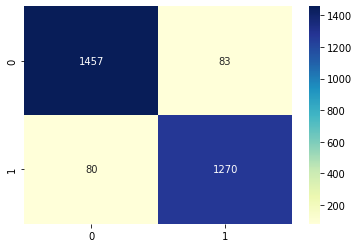

In [ ]:
get_clf_eval(train_actual, train_pred_lst)


정확도: 0.8088
정밀도: 0.8182
재현율: 0.7941
AUC: 0.8088
F1: 0.8088


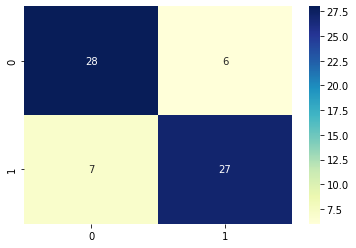

In [ ]:
get_clf_eval(validation_actual, validation_pred_lst)

# Make submission

### Load dataset

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))


        ####################################################################
        ####                 리턴값에 -1 추가해줘야함                   ####
        ####################################################################
        return trans_image, -1, data['file_name']

In [ ]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


## 추론 진행

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, _, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:08,  8.06s/it]

tensor([[9.4084e-01, 5.9159e-02],
        [6.4172e-01, 3.5828e-01],
        [9.1287e-01, 8.7132e-02],
        [3.7799e-03, 9.9622e-01],
        [9.5327e-01, 4.6729e-02],
        [6.5794e-02, 9.3421e-01],
        [1.0978e-01, 8.9022e-01],
        [1.9839e-01, 8.0161e-01],
        [9.1098e-01, 8.9020e-02],
        [2.9819e-03, 9.9702e-01],
        [8.3555e-01, 1.6445e-01],
        [9.2357e-01, 7.6428e-02],
        [9.3737e-01, 6.2631e-02],
        [9.9968e-01, 3.2005e-04],
        [7.5793e-01, 2.4207e-01],
        [6.8966e-01, 3.1034e-01],
        [3.0523e-01, 6.9477e-01]], device='cuda:0')


2it [00:13,  6.60s/it]

tensor([[9.9518e-01, 4.8229e-03],
        [9.7182e-01, 2.8185e-02],
        [9.8718e-01, 1.2824e-02],
        [8.8714e-01, 1.1286e-01],
        [6.7507e-01, 3.2493e-01],
        [6.9712e-01, 3.0288e-01],
        [9.9701e-01, 2.9876e-03],
        [1.1166e-01, 8.8834e-01],
        [9.8537e-01, 1.4626e-02],
        [9.4681e-01, 5.3190e-02],
        [9.9692e-01, 3.0751e-03],
        [7.6210e-01, 2.3790e-01],
        [4.6821e-02, 9.5318e-01],
        [3.1558e-01, 6.8442e-01],
        [8.7185e-04, 9.9913e-01],
        [4.9994e-02, 9.5001e-01],
        [9.4703e-01, 5.2968e-02]], device='cuda:0')


3it [00:19,  6.47s/it]

tensor([[0.3548, 0.6452],
        [0.0742, 0.9258],
        [0.6626, 0.3374],
        [0.7746, 0.2254],
        [0.0168, 0.9832],
        [0.9826, 0.0174],
        [0.0083, 0.9917],
        [0.8823, 0.1177],
        [0.1971, 0.8029],
        [0.0058, 0.9942],
        [0.0056, 0.9944],
        [0.6827, 0.3173],
        [0.6534, 0.3466],
        [0.4153, 0.5847],
        [0.9695, 0.0305],
        [0.8865, 0.1135],
        [0.1481, 0.8519]], device='cuda:0')


4it [00:25,  6.18s/it]

tensor([[2.7819e-04, 9.9972e-01],
        [1.5001e-01, 8.4999e-01],
        [3.7205e-01, 6.2795e-01],
        [2.7773e-01, 7.2227e-01],
        [1.2912e-02, 9.8709e-01],
        [6.0686e-01, 3.9314e-01],
        [2.6936e-02, 9.7306e-01],
        [8.4747e-01, 1.5253e-01],
        [1.4425e-01, 8.5575e-01],
        [2.2618e-01, 7.7382e-01],
        [2.5246e-01, 7.4754e-01],
        [7.3642e-01, 2.6358e-01],
        [7.8114e-01, 2.1886e-01],
        [8.1320e-01, 1.8680e-01],
        [2.6378e-02, 9.7362e-01],
        [9.3019e-01, 6.9813e-02],
        [6.2154e-02, 9.3785e-01]], device='cuda:0')


5it [00:31,  5.91s/it]

tensor([[0.0729, 0.9271],
        [0.9845, 0.0155],
        [0.3157, 0.6843],
        [0.9874, 0.0126],
        [0.5236, 0.4764],
        [0.9987, 0.0013],
        [0.1149, 0.8851],
        [0.7854, 0.2146],
        [0.9961, 0.0039],
        [0.9978, 0.0022],
        [0.0075, 0.9925],
        [0.0637, 0.9363],
        [0.2059, 0.7941],
        [0.8874, 0.1126],
        [0.9719, 0.0281],
        [0.0187, 0.9813],
        [0.7462, 0.2538]], device='cuda:0')


6it [00:35,  5.96s/it]

tensor([[0.1767, 0.8233],
        [0.9960, 0.0040],
        [0.0019, 0.9981],
        [0.6246, 0.3754],
        [0.0339, 0.9661],
        [0.8110, 0.1890],
        [0.4457, 0.5543],
        [0.1236, 0.8764],
        [0.0535, 0.9465],
        [0.9936, 0.0064],
        [0.9597, 0.0403],
        [0.0355, 0.9645],
        [0.0218, 0.9782],
        [0.0696, 0.9304],
        [0.8242, 0.1758]], device='cuda:0')


In [ ]:
prob_lst

[0.059158630669116974,
 0.35827502608299255,
 0.08713150024414062,
 0.9962201714515686,
 0.04672931507229805,
 0.9342062473297119,
 0.8902220726013184,
 0.8016085028648376,
 0.08902015537023544,
 0.9970180988311768,
 0.1644524335861206,
 0.07642757147550583,
 0.06263094395399094,
 0.000320046761771664,
 0.24206528067588806,
 0.3103412091732025,
 0.694769024848938,
 0.004822899121791124,
 0.0281846821308136,
 0.01282438449561596,
 0.1128624677658081,
 0.32493358850479126,
 0.3028775453567505,
 0.0029875661712139845,
 0.8883414268493652,
 0.014625920914113522,
 0.05318951606750488,
 0.003075055778026581,
 0.23789699375629425,
 0.9531794190406799,
 0.6844194531440735,
 0.9991281628608704,
 0.9500063061714172,
 0.05296787619590759,
 0.6451700329780579,
 0.9257652759552002,
 0.33739790320396423,
 0.22538678348064423,
 0.9831732511520386,
 0.017412902787327766,
 0.9917266368865967,
 0.11769857257604599,
 0.8029398322105408,
 0.9941602945327759,
 0.9943736791610718,
 0.31728002429008484,
 0.3

In [ ]:
# test set에 대한 gradcam
# grad_cam(test_dataset, 'test')

NameError: name 'grad_cam' is not defined

## 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv(model_name + '_aug1_prediction.csv', index=False)


dfp = pd.DataFrame({'file_name':file_lst, 'COVID':prob_lst})
# df.sort_values(by=['file_name'], inplace=True)
dfp.to_csv(model_name + '_aug1_pred.csv', index=False)

In [ ]:
wandb.finish()

Early stopping counter,▁▁▂▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▄▄▅▅▆▆▇▇▇▇████████████████
train_loss,██▇▇▇▇▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_accuracy,▁▄▄▄▄▅▄▆▇▇▄▆▆▆▇▅▅▆▇▆▇█▆█▆▇▆▆▇
valid_loss,▃▃▃▃▃▄▂▂▁▂▅▃▅▄▄▅█▇▅▆▇▅▅▄▆█▆█▆
Early stopping counter,20
train_accuracy,0.99481
train_loss,0.02175
valid_accuracy,0.79412
valid_loss,1.24815
